# Are we able to predict if people are French based on if they survived the Titanic?

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true;
function code_toggle() {
if (code_show){
$('div.input').hide();
} else {
$('div.input').show();
}
code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
#get required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

import sklearn
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

from numpy import arange
from sklearn.linear_model import LassoCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import Lasso

pd.set_option('display.max_columns',200) #allows for up to 500 columns to be displayed when viewing a dataframe
pd.set_option('display.max_rows',100)
plt.style.use('seaborn') # a style that can be used for plots - see style reference above

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

- Instead of prediciting survival rate based on embarkation point.
- We want to predict if a passenger was French (embarked from Cherbourg).
- In addition to survival, examined all the variables as potential predictors for the model.

In [17]:
#get data and preview first entries
df = pd.read_csv("Titanic_Data.csv", index_col='PassengerId')
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
#drop Cabin column due to missing values being greater than quantity of known values
#Name and ticket are dropped because they are irrelevant information
df = df.drop(columns = ["Cabin", "Name", "Ticket"])

In [5]:
#drop values with missing target var embarkation point
df = df.drop(labels = [830,62], axis = 0)

In [6]:
#convert sex column from categorical to boolean
# 1 = male, 0 = female
df["Sex"] = pd.get_dummies(df["Sex"])

In [7]:
#convert Embarked column from categorical to boolean
# 1 = Cherbourg, 0 = not Cherbourg
df["Embarked"] = pd.get_dummies(df["Embarked"])

In [8]:
#drop age for initial tests
df_simple = df.drop(columns = 'Age')

Considering age with incomplete information resulted in less accuracy.

Text(0.5, 1.0, 'Survival for Embark Point')

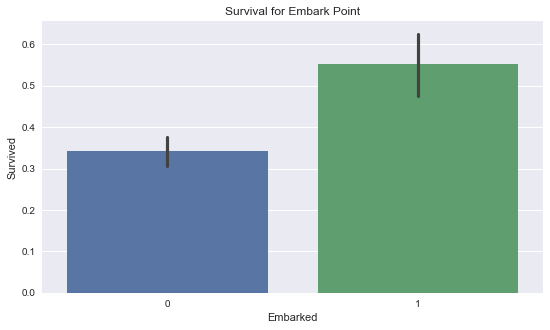

In [9]:
#code from https://towardsdatascience.com/a-complete-guide-to-plotting-categorical-variables-with-seaborn-bfe54db66bec
#visualizes data as percentage survived by Embarked
plt.figure(figsize=(8,5))
sns.barplot(x='Embarked',y='Survived',data = df_simple)
plt.title("Survival for Embark Point")

Text(0.5, 1.0, 'Embarkation Point for Survival')

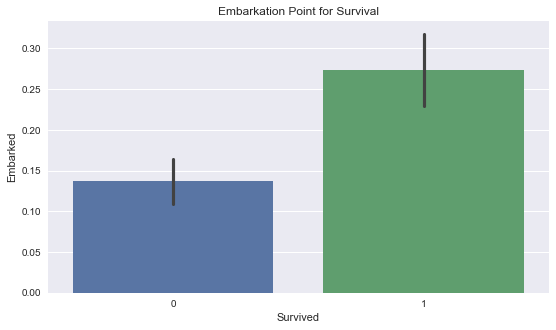

In [10]:
#same chart but with reversed axes, visulizes Embarked by survived
plt.figure(figsize=(8,5))
sns.barplot(x='Survived',y='Embarked',data = df_simple)
plt.title("Embarkation Point for Survival")

Being French = >50% chance of survival

<br> Surviving = >25% chance of being French

<AxesSubplot:>

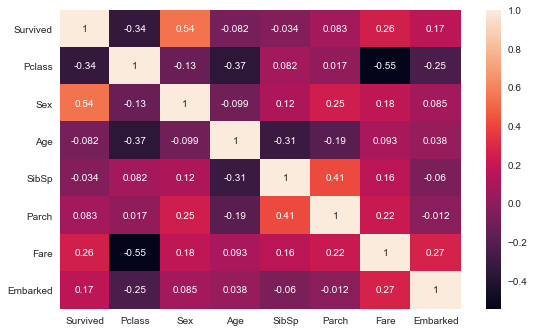

In [11]:
#correlation heatmap
sns.heatmap(df.corr(), annot=True)

Embarking at Chourberg correlates with ticket price

In [12]:
#create X and y data sets, X being predictors, y being the target Embarked
X = df_simple.drop(["Embarked"], axis = 1)
y = df_simple.Embarked

In [13]:
#create train/test split from data to create lasso regression, lasso regression code repurposed from 
# Dr. Ramchandra Rimal's DATA 3550 notes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

iteration 0.005 done
iteration 0.05 done
iteration 0.1 done
iteration 0.5 done
iteration 0.75 done
iteration 1 done
iteration 5 done


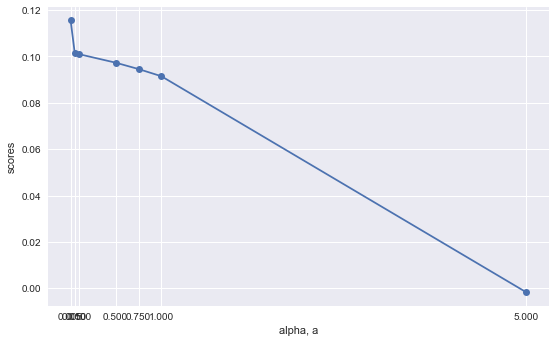

In [14]:
#Test different values for alpha to find best R^2 value

#alpha test value array
alphas = [0.005, 0.05, 0.1, 0.5, 0.75, 1, 5] # here alpha is the lambda in the lecture note, the coefficient of lasso penalty
#bin array for resultant R^2 values
scores = []

#create lasso and test for each value in alphas array
for a in alphas:
    lasso = Lasso(alpha = a, normalize = False, max_iter = 10000) # I choose normalize = False here
    lasso.fit(X_train, y_train)
    #yhat_test=lasso.predict(X_test)
    #scores.append(mean_squared_error(y_test, yhat_test))
    scores.append(lasso.score(X_test, y_test))
    print("iteration {} done".format(a))


#plot result scores against test alpha values
plt.plot(alphas, scores, '-o')
plt.xlabel('alpha, a')
plt.ylabel('scores')
plt.xticks(alphas)
plt.show()

alpha = 0.005

In [15]:
#create lasso regression with best alpha value and get R^2 value
lasso = Lasso(alpha = 0.005, normalize = False, max_iter = 10000)
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)
lasso.score(X_test, y_test)

0.11553937718690399

In [16]:
#create and view df containing resultant beta coefficients for lasso regression
lasso_coef = lasso.fit(X_train, y_train).coef_
df_lasso = pd.DataFrame([lasso_coef])
names = X.columns
df_lasso.columns = names
df_lasso = df_lasso.T
df_lasso=df_lasso.rename(columns = {0:'corr_lasso_coeff'})# corr_lasso_coeff is corresponding lasso coefficients of the variable
df_lasso

,corr_lasso_coeff
Survived,0.056558
Pclass,-0.029650
Sex,0.000000
SibSp,-0.027783
Parch,-0.009658
Fare,0.001754


Gender has no impact <br>
Affluence has a positive impact <br>
Family has a negative impact <br>
Survival has a positive impact <br>
<br>
Successfully explains roughly 12% of Frenchness